In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from google.colab import files
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
!pip install catboost --quiet


In [3]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [7]:
# loading the traning dataset
preprocessed_output_data_path = "https://raw.githubusercontent.com/michaelwozniak/ML-in-Finance-I-case-study-forecasting-tax-avoidance-rates/refs/heads/main/data/output"
df = pd.read_csv(f"{preprocessed_output_data_path}/train_fe.csv", index_col=0)


In [6]:
df.head()

,Ticker,Nazwa2,rok,ta,txt,pi,str,xrd,ni,ppent,...,intan_ma,ppe_ma,sale_ma,cash_holdings_ma,roa_past,lev_past,intan_past,ppe_past,sale_past,cash_holdings_past
0,11B PW Equity,11 bit studios SA,2005,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,...,0.198598,0.013076,0.445954,0.574744,0.240818,0.0,0.198598,0.013076,0.445954,0.574744
1,11B PW Equity,11 bit studios SA,2006,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,...,0.198598,0.013076,0.445954,0.574744,0.240818,0.0,0.198598,0.013076,0.445954,0.574744
2,11B PW Equity,11 bit studios SA,2007,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,...,0.198598,0.013076,0.445954,0.574744,0.240818,0.0,0.198598,0.013076,0.445954,0.574744
3,11B PW Equity,11 bit studios SA,2008,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,...,0.198598,0.013076,0.445954,0.574744,0.240818,0.0,0.198598,0.013076,0.445954,0.574744
4,11B PW Equity,11 bit studios SA,2009,21.127613,1.24185,6.329725,0.19,0.0,5.0879,0.276275,...,0.198598,0.013076,0.445954,0.574744,0.240818,0.0,0.198598,0.013076,0.445954,0.574744


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3993 entries, 0 to 4354
Columns: 115 entries, Ticker to cash_holdings_past
dtypes: float64(57), int64(56), object(2)
memory usage: 3.5+ MB


In [8]:
print(df.columns)

Index(['Ticker', 'Nazwa2', 'rok', 'ta', 'txt', 'pi', 'str', 'xrd', 'ni',
       'ppent',
       ...
       'intan_ma', 'ppe_ma', 'sale_ma', 'cash_holdings_ma', 'roa_past',
       'lev_past', 'intan_past', 'ppe_past', 'sale_past',
       'cash_holdings_past'],
      dtype='object', length=115)


In [9]:
# check if there are some missing values
missing = df.isnull().sum()
print(missing[missing > 0])

Series([], dtype: int64)


In [10]:
# drop 2 first columns
df.drop(['Ticker', 'Nazwa2'], axis=1, inplace=True)

# sort base on rok column
df.sort_values('rok', inplace=True)

In [11]:
# check how many year has been analyzed
df['rok'].unique()

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])

In [12]:
# No need to do more Feature Engineering
# Feature Selection
fr = pd.read_excel(f"{preprocessed_output_data_path}/feature_ranking.xlsx", index_col=0)
fr.head()

,mi_score,sign_fscore,sign_fscore_0_1,corr,EN_coef,boruta_rank
rok,0.032073,1.179353e-01,0,-0.032669,0.000000e+00,19
ta,0.582922,1.464884e-03,1,0.267340,-1.404307e-07,49
txt,0.633067,5.246456e-13,1,0.368732,1.466269e-05,1
pi,0.608157,8.614688e-12,1,0.299593,8.453656e-06,3
str,0.293955,1.578384e-46,1,0.372870,NaN,9


In [13]:
fr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, rok to cash_holdings_past
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mi_score         112 non-null    float64
 1   sign_fscore      112 non-null    float64
 2   sign_fscore_0_1  112 non-null    int64  
 3   corr             111 non-null    float64
 4   EN_coef          20 non-null     float64
 5   boruta_rank      112 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 10.2+ KB


In [14]:
# define X_train and y_train with all features
X_full = df.drop('etr', axis=1).copy()
y_full = df['etr'].copy()

In [15]:
X_full.head()

,rok,ta,txt,pi,str,xrd,ni,ppent,intant,dlc,...,intan_ma,ppe_ma,sale_ma,cash_holdings_ma,roa_past,lev_past,intan_past,ppe_past,sale_past,cash_holdings_past
468,2005,36722.000000,538.000000,1912.000000,0.282890,1729.000000,1597.000000,8321.000000,15363.000000,7185.000000,...,0.424188,0.192621,0.465927,0.070874,0.043489,0.243778,0.418360,0.226594,0.514408,0.089592
4176,2005,192.700302,1.443167,7.148633,0.190000,0.000000,5.665789,111.691917,39.267090,24.036644,...,0.203773,0.579615,0.422354,0.034305,0.029402,0.216960,0.203773,0.579615,0.422354,0.034305
4164,2005,5369.179199,124.015999,497.527008,0.250000,60.000000,323.093994,2166.589111,309.833008,697.372986,...,0.058119,0.390033,0.714793,0.058196,0.060176,0.216039,0.057706,0.403523,0.730613,0.033057
504,2005,2758.899902,112.199997,394.299988,0.239722,282.100006,11.300000,0.000000,0.000000,101.000000,...,0.000000,0.000000,0.632419,0.059361,0.004096,0.075175,0.000000,0.000000,0.642176,0.103338
492,2005,43.483585,0.286833,1.070500,0.190000,0.000000,0.783667,3.384500,2.567167,1.164500,...,0.046302,0.096693,1.300568,0.126897,0.018022,0.062368,0.059038,0.077834,1.228043,0.121638


In [16]:
y_full.head()

,etr
468,0.229293
4176,0.201880
4164,0.229173
504,0.297394
492,0.243836


In [17]:
def year_rolling_splits(years_array, min_train_years=1):
    """
    Expanding-window rolling splits by year.

    """
    years_array = np.asarray(years_array)
    unique_years = np.sort(np.unique(years_array))

    for i in range(min_train_years, len(unique_years)):
        # All past years for training
        train_years = unique_years[:i]
        # Next year for validation
        val_year = unique_years[i]

        train_idx = np.where(np.isin(years_array, train_years))[0]
        val_idx = np.where(years_array == val_year)[0]

        yield train_idx, val_idx

In [18]:
# ---- build cv_splits list ----
years_array = df["rok"].values

# drop rok from X
X_full.drop("rok", axis=1, inplace=True)


In [4]:
import re

def clean_feature_names(features):
    cleaned = []
    for f in features:
        s = str(f)
        # replace any non-alphanumeric or underscore with underscore
        s = re.sub(r'[^0-9a-zA-Z_]', '_', s)
        cleaned.append(s)
    return cleaned

In [299]:
def select_top_features(
    X,
    model_feature_importances=None,  # list of features from fitted model
    feature_importance_scores=None,  # list of importance scores
    fr=None,                         # external feature ranking (DataFrame)
    top_n_candidates=[20, 30, 50]    # list of top-N values to select
):
    """
    Select multiple top-N feature subsets by combining model importance scores
    with external FR scores. Cleans feature names to be compatible with XGBoost.
    """

    # Clean X column names

    X_cleaned = X.copy()
    X_cleaned.columns = clean_feature_names(X_cleaned.columns)

    # Fallback for model_feature_importances
    if model_feature_importances is None or len(model_feature_importances) == 0:
        model_feature_importances = list(X_cleaned.columns)

    else:
        # clean them with the same rule
        model_feature_importances = clean_feature_names(model_feature_importances)

    # Fallback for feature_importance_scores
    if feature_importance_scores is None or len(feature_importance_scores) == 0:
        feature_importance_scores = np.linspace(1, 0.1, len(model_feature_importances))

    # Combine model scores with external FR
    combined_df = pd.DataFrame({"model": feature_importance_scores}, index=model_feature_importances)
    if fr is not None and not fr.empty:
        fr_cleaned = fr.copy()
        fr_cleaned.index = clean_feature_names(fr_cleaned.index)
        combined_df = combined_df.join(fr_cleaned, how="outer")

    # Compute average score across all columns
    combined_scores = combined_df.mean(axis=1).sort_values(ascending=False)

    # Generate top-N subsets
    subsets_dict = {}
    features_dict = {}
    for top_n in top_n_candidates:
        selected_features = combined_scores.index[:top_n].tolist()
        X_subset = X_cleaned[selected_features]
        subsets_dict[top_n] = X_subset
        features_dict[top_n] = selected_features

    return subsets_dict, combined_scores, features_dict

In [301]:
def optimize_features_with_rolling_cv(
    X,
    y,
    years_array,
    rolling_cv_func,
    model_feature_importances=None,
    feature_importance_scores=None,
    fr=None,
    top_n_candidates=[20, 30, 50],
    min_train_years=1,
    n_jobs=-1,
    verbose=1
):
    """
    Optimize top-N features using rolling CV while ensuring
    all feature names are clean and aligned with X.
    """

    # ======================================================
    # STEP 0 — Clean X ONCE and build a mapping
    # ======================================================
    X_cleaned = X.copy()
    original_cols = list(X.columns)
    cleaned_cols = clean_feature_names(original_cols)

    # map: original → cleaned
    col_map = {orig: cleaned for orig, cleaned in zip(original_cols, cleaned_cols)}

    # apply cleaned names
    X_cleaned.columns = cleaned_cols


    # ======================================================
    # STEP 1 — Run top-N selection on the CLEANED X
    # ======================================================
    subsets_dict, combined_scores, features_dict = select_top_features(
        X=X_cleaned,
        model_feature_importances=model_feature_importances,
        feature_importance_scores=feature_importance_scores,
        fr=fr,
        top_n_candidates=top_n_candidates
    )


    # ======================================================
    # STEP 2 — Align features_dict with cleaned X names
    # IMPORTANT:
    #   select_top_features(X_cleaned, ...) returns CLEAN names already
    #   so we DO NOT clean them again (fixes your KeyError!)
    # ======================================================
    for top_n in top_n_candidates:
        feats = features_dict[top_n]

        # keep only those present in X_cleaned.columns
        feats = [f for f in feats if f in X_cleaned.columns]

        features_dict[top_n] = feats
        subsets_dict[top_n] = X_cleaned[feats]


    # ======================================================
    # STEP 3 — Rolling CV on each subset
    # ======================================================
    results_list = []

    for top_n in top_n_candidates:
        X_subset = subsets_dict[top_n]
        selected_features = features_dict[top_n]

        if verbose:
            print(f"\nRunning rolling CV for top-{top_n} features...")

        best_model_cv, best_features_cv, cv_results_df = rolling_cv_func(
            X=X_subset,
            y=y,
            years_array=years_array,
            min_train_years=min_train_years,
            n_jobs=n_jobs,
            verbose=verbose
        )

        best_rmse = cv_results_df["cv_rmse"].min()

        results_list.append({
            "top_n": top_n,
            "num_features": len(selected_features),
            "cv_rmse": best_rmse,
            "model": best_model_cv,
            "features": selected_features
        })


    # ======================================================
    # STEP 4 — Pick best top-N
    # ======================================================
    results_df = pd.DataFrame(results_list).sort_values("cv_rmse").reset_index(drop=True)
    best_row = results_df.iloc[0]

    best_model = best_row["model"]
    best_features = best_row["features"]

    if verbose:
        print(f"\nBest top-N: {best_row['top_n']}, "
              f"num_features: {len(best_features)}, "
              f"CV RMSE: {best_row['cv_rmse']:.4f}")

    return best_model, best_features, results_df


In [302]:
def get_feature_importance_df(model, feature_names):
    importances = model.feature_importances_
    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
    return fi_df

def plot_feature_importances(fi_df, model_name="Model", top_n=None, figsize=(8, 6)):
    if top_n is not None:
        fi_df = fi_df.head(top_n)

    plt.figure(figsize=figsize)
    plt.barh(fi_df["feature"], fi_df["importance"])
    plt.gca().invert_yaxis() # highest importance at top
    plt.xlabel("Importance")
    plt.title(f"{model_name} Feature Importances")
    plt.tight_layout()
    plt.show()

In [303]:
from sklearn.feature_selection import SelectFromModel

def find_best_threshold_with_cv_model(
    base_model,
    X,
    y,
    years_array,
    feature_names,
    thresholds,
    rolling_cv_func,
    min_train_years=1,
    n_jobs=-1,
    verbose=1,
):
    """
    Select the best feature importance threshold for any model using rolling CV.

    """

    results_list = []
    extra_info = {}

    for thresh in thresholds:
        # Select features based on importance
        selector = SelectFromModel(base_model, threshold=thresh, prefit=True)
        selected_idx = selector.get_support(indices=True)
        selected_features = [feature_names[i] for i in selected_idx]
        num_features = len(selected_features)

        if num_features == 0:
            if verbose:
                print(f"Threshold {thresh}: No features selected, skipping...")
            continue

        X_reduced = pd.DataFrame(selector.transform(X), columns=selected_features)
        if verbose:
            print(f"\nThreshold {thresh}: {num_features} features selected")

        # Run rolling CV
        # Ensure rolling_cv_func returns exactly (best_model, best_features, cv_results_df)
        best_model_cv, cv_results_df, _ = rolling_cv_func(
            X=X_reduced,
            y=y,
            years_array=years_array,
            min_train_years=min_train_years,
            n_jobs=n_jobs,
            verbose=verbose,
        )

        # Extract best RMSE from cv_results_df
        best_rmse = np.sqrt(-cv_results_df.best_score_)

        results_list.append({
            "threshold": thresh,
            "num_features": num_features,
            "cv_rmse": best_rmse
        })

        extra_info[thresh] = {
            "features": selected_features,
            "model": best_model_cv
        }

    if not results_list:
        raise ValueError("No features selected for any threshold!")

    results_df = pd.DataFrame(results_list).sort_values("cv_rmse").reset_index(drop=True)
    best_threshold = results_df.iloc[0]["threshold"]
    best_features = extra_info[best_threshold]["features"]
    best_model = extra_info[best_threshold]["model"]

    if verbose:
        print(
            f"\nBest threshold: {best_threshold}, "
            f"num_features: {len(best_features)}, "
            f"CV RMSE: {results_df.iloc[0]['cv_rmse']:.4f}"
        )

    return results_df, best_threshold, best_features, best_model


In [304]:
def save_and_download_model(model, features, filename="model.pkl"):
    """
    Save a model and its features to a pickle file and download it in Colab.

    """
    # Save model + features
    with open(filename, "wb") as f:
        pickle.dump((model, features), f)

    # Download the pickle file
    files.download(filename)


1. AdaBoost

In [25]:
def rolling_cv_adaboost_by_year(
    X,
    y,
    years_array,
    min_train_years=1,
    n_jobs=-1,
    verbose=1,
):
    """
    Perform rolling cross-validation by year for AdaBoost with hyperparameter tuning
    using GridSearchCV.


    """
    # 1) Build rolling splits by year
    cv_splits = list(year_rolling_splits(years_array, min_train_years=min_train_years))

    # 2) Base AdaBoost model
    base_tree = DecisionTreeRegressor(max_depth=1, random_state=42)
    ada = AdaBoostRegressor(estimator=base_tree, random_state=42)

    # 3) Hyperparameter grid
    param_grid = {
        "n_estimators": [100, 200, 300, 400],
        "learning_rate": [0.05, 0.07, 0.1, 0.15],
    }

    # 4) Grid search with neg_mean_squared_error
    grid_search = GridSearchCV(
        estimator=ada,
        param_grid=param_grid,
        cv=cv_splits,
        scoring="neg_mean_squared_error",
        n_jobs=n_jobs,
        verbose=verbose,
    )

    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # Convert best_score_ (negative MSE) to RMSE
    best_rmse = np.sqrt(-grid_search.best_score_)
    cv_results_df = pd.DataFrame({"cv_rmse": [best_rmse]})


    print("Best parameters (AdaBoost):", grid_search.best_params_)
    print("Best CV RMSE (AdaBoost):", best_rmse)

    return best_model, grid_search,  cv_results_df

In [26]:
# hyperparameter tuning
best_ada, ada_search, _ = rolling_cv_adaboost_by_year(
    X=X_full,
    y=y_full,
    years_array=years_array,
    min_train_years=1
)

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters (AdaBoost): {'learning_rate': 0.05, 'n_estimators': 100}
Best CV RMSE (AdaBoost): 0.15692261760962342


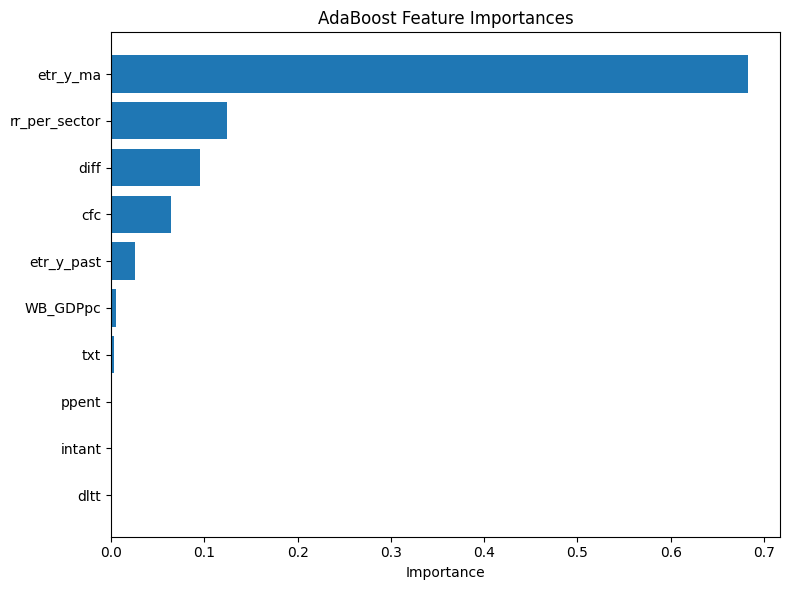

In [29]:
feature_importance_ada = get_feature_importance_df(best_ada, X_full.columns.tolist())
plot_feature_importances(feature_importance_ada, model_name="AdaBoost", top_n=10)

In [34]:
# Selecting Important Features
feature_names = X_full.columns.tolist()
thresholds = [0.001, 0.005]
results_df, best_thresh, best_features_ada, best_model_ada = find_best_threshold_with_cv_model(
    base_model=best_ada,
    X=X_full,
    y=y_full,
    years_array=years_array,
    feature_names=feature_names,
    thresholds=thresholds,
    rolling_cv_func=rolling_cv_adaboost_by_year,
    min_train_years=1,
    n_jobs=-1,
    verbose=1
)


Threshold 0.001: 7 features selected
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters (AdaBoost): {'learning_rate': 0.05, 'n_estimators': 100}
Best CV RMSE (AdaBoost): 0.15637114303981675

Threshold 0.005: 5 features selected
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters (AdaBoost): {'learning_rate': 0.05, 'n_estimators': 100}
Best CV RMSE (AdaBoost): 0.1566722379999105

Best threshold: 0.001, num_features: 7, CV RMSE: 0.1564


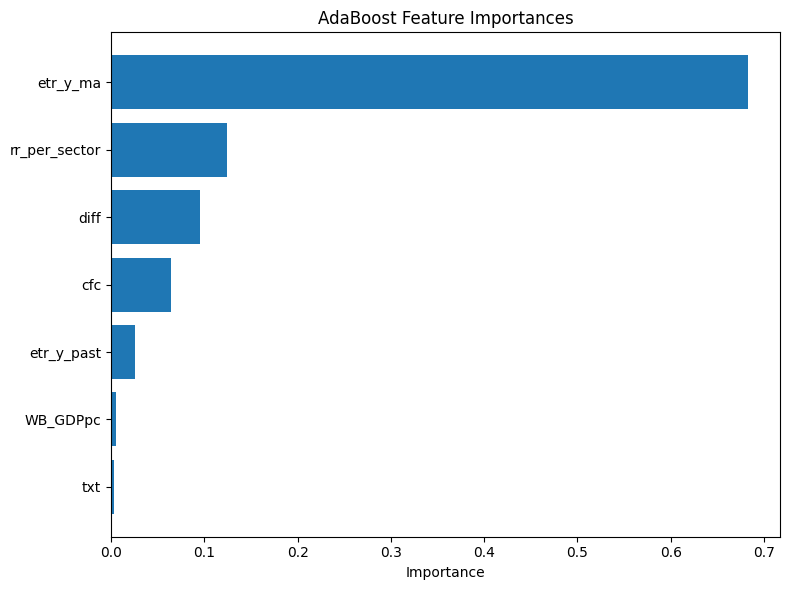

In [35]:
# feature importance
feature_importance_ada = get_feature_importance_df(best_model_ada, best_features_ada)
plot_feature_importances(feature_importance_ada, model_name="AdaBoost", top_n=10)

In [36]:
ada_best_model, ada_best_features, ada_results_df = optimize_features_with_rolling_cv(
    X=X_full,
    y=y_full,
    years_array=years_array,
    rolling_cv_func=rolling_cv_adaboost_by_year,
    fr=fr,
    top_n_candidates=[5, 10, 20, 30, 50],
    verbose=1
)


Running rolling CV for top-5 features...
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters (AdaBoost): {'learning_rate': 0.1, 'n_estimators': 100}
Best CV RMSE (AdaBoost): 0.1602262034813975

Running rolling CV for top-10 features...
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters (AdaBoost): {'learning_rate': 0.1, 'n_estimators': 100}
Best CV RMSE (AdaBoost): 0.1594979796890947

Running rolling CV for top-20 features...
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters (AdaBoost): {'learning_rate': 0.1, 'n_estimators': 100}
Best CV RMSE (AdaBoost): 0.15882865559864492

Running rolling CV for top-30 features...
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters (AdaBoost): {'learning_rate': 0.15, 'n_estimators': 100}
Best CV RMSE (AdaBoost): 0.15779095219317246

Running rolling CV for top-50 features...
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best

In [37]:
# choose the best model based on rmse
best_ada = best_model_ada

In [41]:
# save as a pickle file
save_and_download_model(best_ada, best_features_ada, "best_ada.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2. Gradient Boosting Machine

In [42]:
def rolling_cv_gbm_by_year(
    X,
    y,
    years_array,
    min_train_years=1,
    n_iter=30,
    n_jobs=-1,
    verbose=1,
    validation_fraction=0.1,
    n_iter_no_change=10,

):
    """
    Perform rolling cross-validation by year for GBM with hyperparameter tuning.
    """
    # 1) Build rolling splits by year
    cv_splits = list(year_rolling_splits(years_array, min_train_years=min_train_years))

    # 2) GBM model
    gbm = GradientBoostingRegressor(
        random_state=42,
        validation_fraction=validation_fraction,
        n_iter_no_change=n_iter_no_change,
    )

    # 3) Hyperparameter grid
    param_search = {
        "n_estimators": [50, 100, 200, 300, 500],
        "learning_rate": [0.03, 0.05, 0.07, 0.1, 0.15],
        "max_depth": [3, 4, 5],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 5, 10],
        "subsample": [0.6, 0.8, 1.0],
    }

    # 4) Randomized search with neg_mean_squared_error
    random_search = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_search,
        n_iter=n_iter,
        cv=cv_splits,
        scoring="neg_mean_squared_error",
        n_jobs=n_jobs,
        verbose=verbose,
    )

    random_search.fit(X, y)
    best_model = random_search.best_estimator_

    # Convert best_score_ (negative MSE) to RMSE
    best_rmse = np.sqrt(-random_search.best_score_)
    cv_results_df = pd.DataFrame({"cv_rmse": [best_rmse]})


    print("Best parameters:", random_search.best_params_)
    print("Best CV RMSE:", best_rmse)

    return best_model, random_search, cv_results_df

In [44]:
# hyperparameter tuning
best_gbm, gbm_random, _ = rolling_cv_gbm_by_year(
    X=X_full,
    y=y_full,
    years_array=years_array,
    min_train_years=1,
    validation_fraction=0.1,
    n_iter_no_change=10,
)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 4, 'learning_rate': 0.03}
Best CV RMSE: 0.14773596179493617


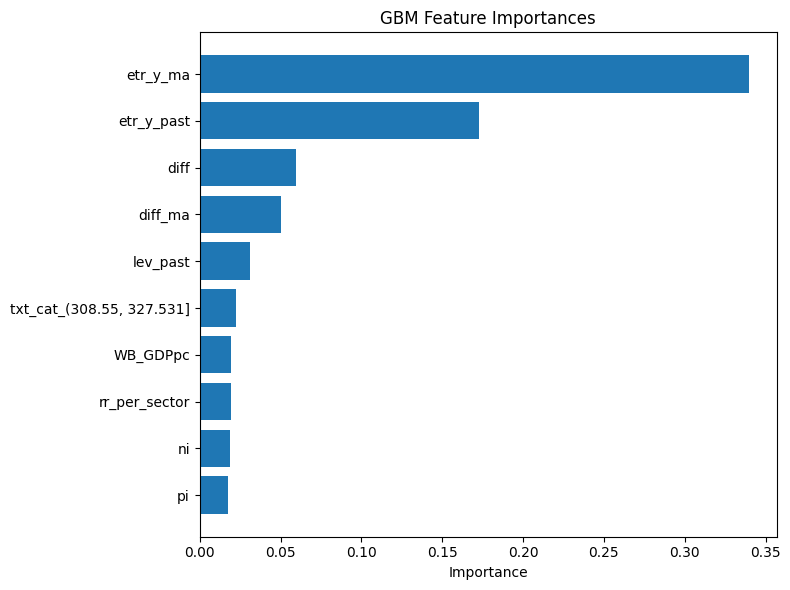

In [45]:
# feature importance
feature_importance_gbm = get_feature_importance_df(best_gbm, X_full.columns.tolist())
plot_feature_importances(feature_importance_gbm, model_name="GBM", top_n=10)

In [46]:
# Selecting Important Features
feature_names = X_full.columns.tolist()
thresholds = [0.001, 0.002, 0.005]
results_df, best_thresh, best_features_gbm, best_model_gbm = find_best_threshold_with_cv_model(
    base_model=best_gbm,
    X=X_full,
    y=y_full,
    years_array=years_array,
    feature_names=feature_names,
    thresholds=thresholds,
    rolling_cv_func=rolling_cv_gbm_by_year,
    min_train_years=1,
    n_jobs=-1,
    verbose=1
)


Threshold 0.001: 52 features selected
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 3, 'learning_rate': 0.03}
Best CV RMSE: 0.1479033832394413

Threshold 0.002: 43 features selected
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.03}
Best CV RMSE: 0.14867026811127118

Threshold 0.005: 30 features selected
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 5, 'learning_rate': 0.03}
Best CV RMSE: 0.14781259695088791

Best threshold: 0.005, num_features: 30, CV RMSE: 0.1478


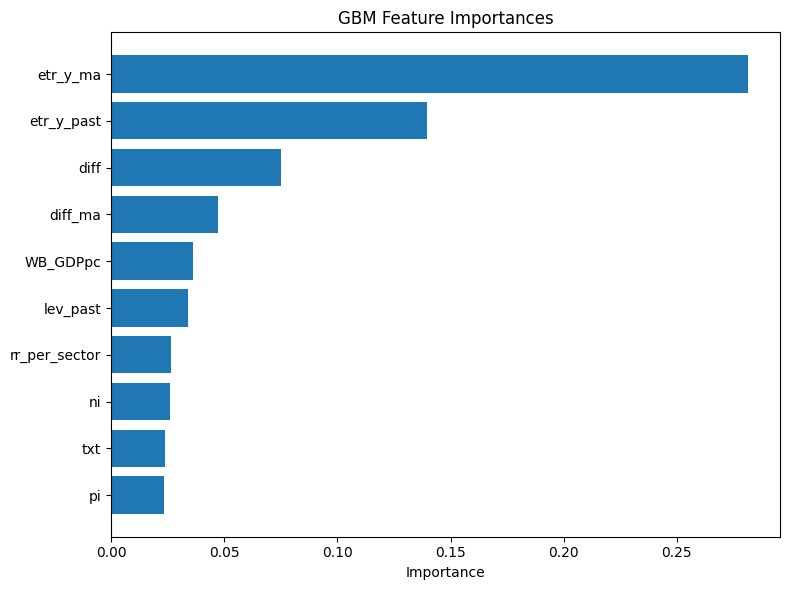

In [47]:
# feature importance
feature_importance_gbm = get_feature_importance_df(best_model_gbm, best_features_gbm)
plot_feature_importances(feature_importance_gbm, model_name="GBM", top_n=10)

In [49]:
gbm_best_model, gbm_best_features, gbm_results_df = optimize_features_with_rolling_cv(
    X=X_full,
    y=y_full,
    years_array=years_array,
    rolling_cv_func=rolling_cv_gbm_by_year,
    fr=fr,
    top_n_candidates=[30, 40, 50],
    verbose=1
)


Running rolling CV for top-30 features...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5, 'learning_rate': 0.07}
Best CV RMSE: 0.1487006050604121

Running rolling CV for top-40 features...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 3, 'learning_rate': 0.15}
Best CV RMSE: 0.1472275892466497

Running rolling CV for top-50 features...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_depth': 3, 'learning_rate': 0.07}
Best CV RMSE: 0.14649212099049938

Best top-N: 50, num_features: 50, CV RMSE: 0.1465


In [50]:
# choose the best model based on rmse
best_gbm = gbm_best_model

In [51]:
# save as a pickle file
save_and_download_model(best_gbm , gbm_best_features, "best_gbm.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

3. GBM histogram

In [53]:
def rolling_cv_histgb_by_year(
    X,
    y,
    years_array,
    min_train_years=1,
    scoring="neg_mean_squared_error",
    n_iter=30,
    n_jobs=-1,
    verbose=1,
    random_state=42
):
    """
    Perform rolling cross-validation by year for HistGradientBoostingRegressor
    with hyperparameter tuning using RandomizedSearchCV and early stopping.
    """

    # 1) Build rolling splits by year
    cv_splits = list(year_rolling_splits(years_array, min_train_years=min_train_years))

    # 2) Define HistGradientBoostingRegressor with early stopping
    gbm_hist = HistGradientBoostingRegressor(
        random_state=random_state,
        early_stopping=True,
    )

    # 3) Hyperparameter distributions for RandomizedSearch
    param_distributions = {
        'max_iter': [50, 100, 200, 300, 400],
        'learning_rate': [0.03, 0.05, 0.07, 0.1, 0.15],
        'max_leaf_nodes': [31, 63, 127],
        'max_bins': [32, 64, 128, 255],
        'min_samples_leaf': [20, 50, 100],
        'l2_regularization': [0.0, 0.1, 0.5],
        'max_features': [0.6, 0.8, 1.0]
    }

    # 4) Randomized search with rolling splits
    rand_search = RandomizedSearchCV(
        estimator=gbm_hist,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv_splits,
        scoring=scoring,
        n_jobs=n_jobs,
        verbose=verbose,
        random_state=random_state
    )

    rand_search.fit(X, y)

    best_model = rand_search.best_estimator_

    # Convert best_score_ (negative MSE) to positive RMSE
    best_mse = -rand_search.best_score_
    best_rmse = np.sqrt(best_mse)
    cv_results_df = pd.DataFrame({"cv_rmse": [best_rmse]})

    print("Best parameters:", rand_search.best_params_)
    print("Best CV RMSE:", best_rmse)
    return best_model, rand_search, cv_results_df


In [54]:
# hyperparameter tuning
best_gbm_hist, gbm_hist_random, _ = rolling_cv_histgb_by_year(
    X=X_full,
    y=y_full,
    years_array=years_array,
    min_train_years=1,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'min_samples_leaf': 100, 'max_leaf_nodes': 63, 'max_iter': 50, 'max_features': 0.8, 'max_bins': 128, 'learning_rate': 0.05, 'l2_regularization': 0.0}
Best CV RMSE: 0.14750519449164753


In [55]:
from sklearn.inspection import permutation_importance

def plot_top_features_histgb(model, X, y, top_n=10, n_repeats=10, random_state=42, n_jobs=-1):
    """
    Compute permutation importance for a fitted HistGradientBoostingRegressor
    and plot the top N features.

    """

    # Compute permutation importance
    perm_imp = permutation_importance(
        model,
        X,
        y,
        n_repeats=n_repeats,
        random_state=random_state,
        n_jobs=n_jobs
    )

    # Create a DataFrame for sorting
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': perm_imp.importances_mean
    })

    # Sort by importance
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    # Select top N features
    top_features = feature_importances.head(top_n)

    # Plot horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='blue')
    plt.xlabel("Permutation Importance")
    plt.title(f"Top {top_n} Features - HistGradientBoostingRegressor")
    plt.show()

    return feature_importances


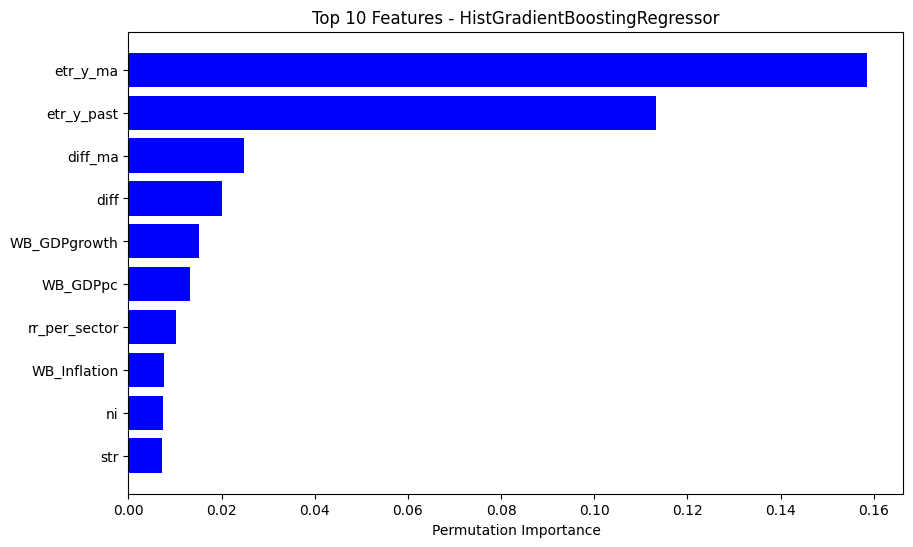

In [56]:
feature_importances_df = plot_top_features_histgb(
    model=best_gbm_hist,
    X=X_full,
    y=y_full,
    top_n=10,
    n_repeats=10
)

In [58]:
# Selecting Important Features
# Compute permutation importance on the fitted HistGradientBoostingRegressor
perm_imp = permutation_importance(best_gbm_hist, X_full, y_full, n_repeats=10, random_state=42, n_jobs=-1)

# Attach feature_importances_ attribute to the fitted model
best_gbm_hist.feature_importances_ = perm_imp.importances_mean

feature_names = X_full.columns.tolist()
thresholds = [0.001, 0.002, 0.005]
results_df, best_thresh, best_features_gbm_hist, best_model_gbm_hist =  find_best_threshold_with_cv_model(
    base_model=best_gbm_hist,
    X=X_full,
    y=y_full,
    years_array=years_array,
    feature_names=feature_names,
    thresholds=thresholds,
    rolling_cv_func=rolling_cv_histgb_by_year,
    min_train_years=1,
    n_jobs=-1,
    verbose=1
)


Threshold 0.001: 37 features selected
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'min_samples_leaf': 100, 'max_leaf_nodes': 63, 'max_iter': 50, 'max_features': 0.8, 'max_bins': 128, 'learning_rate': 0.05, 'l2_regularization': 0.0}
Best CV RMSE: 0.14764221303465147

Threshold 0.002: 29 features selected
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'min_samples_leaf': 100, 'max_leaf_nodes': 63, 'max_iter': 50, 'max_features': 0.8, 'max_bins': 128, 'learning_rate': 0.05, 'l2_regularization': 0.0}
Best CV RMSE: 0.14747410575246084

Threshold 0.005: 15 features selected
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'min_samples_leaf': 100, 'max_leaf_nodes': 63, 'max_iter': 50, 'max_features': 0.8, 'max_bins': 128, 'learning_rate': 0.05, 'l2_regularization': 0.0}
Best CV RMSE: 0.14756022759030937

Best threshold: 0.002, num_features: 29, CV RMSE: 0.1475


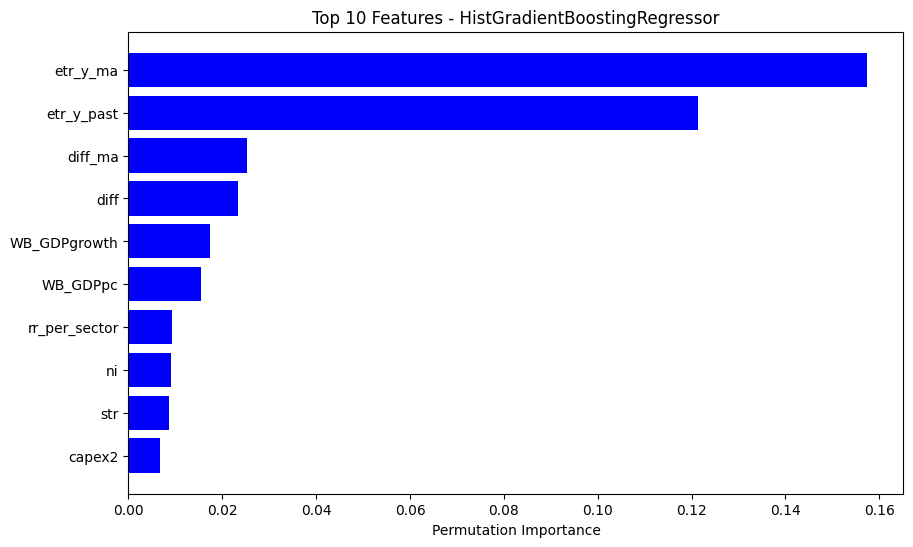

In [59]:
X_best = X_full[best_features_gbm_hist]
feature_importances_df = plot_top_features_histgb(
    model=best_model_gbm_hist,
    X=X_best,
    y=y_full,
    top_n=10,
    n_repeats=10
)

In [61]:
gbm_hist_best_model, gbm_hist_best_features, gbm_hist_results_df = optimize_features_with_rolling_cv(
    X=X_full,
    y=y_full,
    years_array=years_array,
    rolling_cv_func=rolling_cv_histgb_by_year,
    fr=fr,
    top_n_candidates=[10, 20, 30],
    verbose=1
)


Running rolling CV for top-10 features...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'min_samples_leaf': 50, 'max_leaf_nodes': 127, 'max_iter': 100, 'max_features': 0.8, 'max_bins': 128, 'learning_rate': 0.15, 'l2_regularization': 0.1}
Best CV RMSE: 0.15281906356039263

Running rolling CV for top-20 features...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'min_samples_leaf': 20, 'max_leaf_nodes': 63, 'max_iter': 50, 'max_features': 0.6, 'max_bins': 128, 'learning_rate': 0.15, 'l2_regularization': 0.0}
Best CV RMSE: 0.15151419422675036

Running rolling CV for top-30 features...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'min_samples_leaf': 50, 'max_leaf_nodes': 127, 'max_iter': 100, 'max_features': 0.8, 'max_bins': 255, 'learning_rate': 0.03, 'l2_regularization': 0.0}
Best CV RMSE: 0.14844889288420052

Best top-N: 30, num_features: 30, CV RMSE: 0.1484


In [ ]:
# choose the best model based on rmse
best_gbm_hist = best_model_gbm_hist

In [62]:
# save as a pickle file
save_and_download_model(best_gbm_hist , best_features_gbm_hist, "best_gbm_hist.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

4. XGBoost

In [76]:
def rolling_cv_xgboost_by_year_random(
    X,
    y,
    years_array,
    min_train_years=1,
    n_iter=30,
    n_jobs=-1,
    verbose=1
):
    """
    Rolling CV by year for XGBoost with RandomizedSearchCV and early stopping.

    """
    # 1) Build rolling splits
    cv_splits = list(year_rolling_splits(years_array, min_train_years=min_train_years))

    # 2) Base XGBRegressor
    xgb = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_estimators=300,
        n_jobs=n_jobs
    )

    # 3) Hyperparameter options (tweak as needed)
    param_distributions = {
        "n_estimators": [50, 100, 200, 300, 400],
        "learning_rate": [0.03, 0.05, 0.07, 0.1, 0.15],
        "gamma": [0, 0.1, 0.2, 0.5, 1],
        "min_child_weight": [1, 2, 3, 5],
        "max_depth": [4, 5, 6, 7],
        "colsample_bytree": [0.8, 0.9, 1.0],
        "reg_lambda": [0, 0.5, 1, 2],
    }

    # 4) Randomized Search using the cv_splits
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv_splits,
        scoring="neg_mean_squared_error",
        n_jobs=n_jobs,
        verbose=verbose,
        random_state=42
    )

    random_search.fit(X, y)

    best_model = random_search.best_estimator_
    best_mse = -random_search.best_score_
    best_rmse = np.sqrt(best_mse)
    cv_results_df = pd.DataFrame({"cv_rmse": [best_rmse]})


    print("Best parameters:", random_search.best_params_)
    print("Best CV RMSE:", best_rmse)

    return best_model, random_search, cv_results_df

In [77]:
X_cleaned = X_full.copy()
X_cleaned.columns = clean_feature_names(X_cleaned.columns)
best_xgb, xgb_random, _ = rolling_cv_xgboost_by_year_random(
    X=X_cleaned,
    y=y_full,
    years_array=years_array,
    min_train_years=1,
    n_iter=30,
    n_jobs=-1,
    verbose=1,
)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'reg_lambda': 2, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.8}
Best CV RMSE: 0.14677937667705354


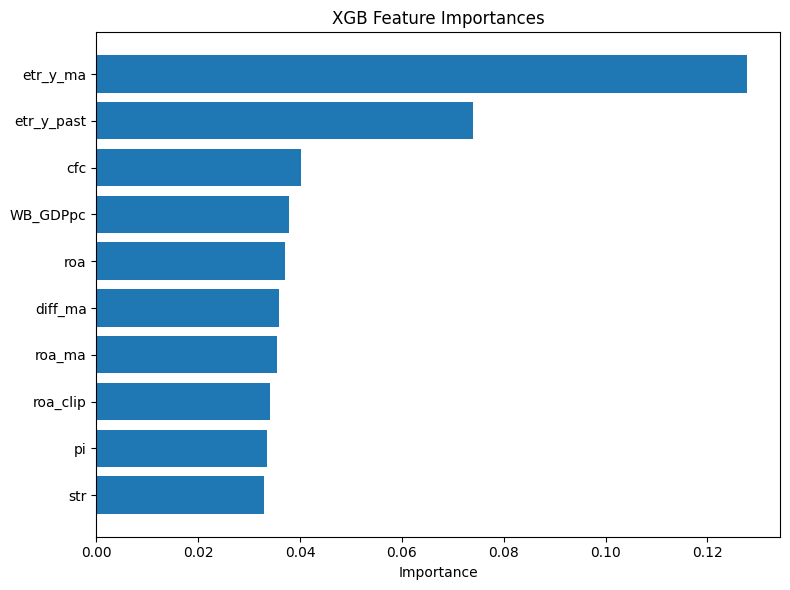

In [78]:
# feature importance
feature_importance_xgb = get_feature_importance_df(best_xgb, X_cleaned.columns.tolist())
plot_feature_importances(feature_importance_xgb, model_name="XGB", top_n=10)

In [87]:
# Selecting Important Features
feature_names = X_cleaned.columns.tolist()
thresholds = [0.03, 0.01]
results_df, best_thresh, best_features_xgb, best_model_xgb = find_best_threshold_with_cv_model(
    base_model=best_xgb,
    X=X_cleaned,
    y=y_full,
    years_array=years_array,
    feature_names=feature_names,
    thresholds=thresholds,
    rolling_cv_func=rolling_cv_xgboost_by_year_random,
    min_train_years=1,
    n_jobs=-1,
    verbose=1
)


Threshold 0.03: 15 features selected
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'reg_lambda': 2, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8}
Best CV RMSE: 0.14650767206498497

Threshold 0.01: 28 features selected
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'reg_lambda': 2, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.8}
Best CV RMSE: 0.14690317615961565

Best threshold: 0.03, num_features: 15, CV RMSE: 0.1465


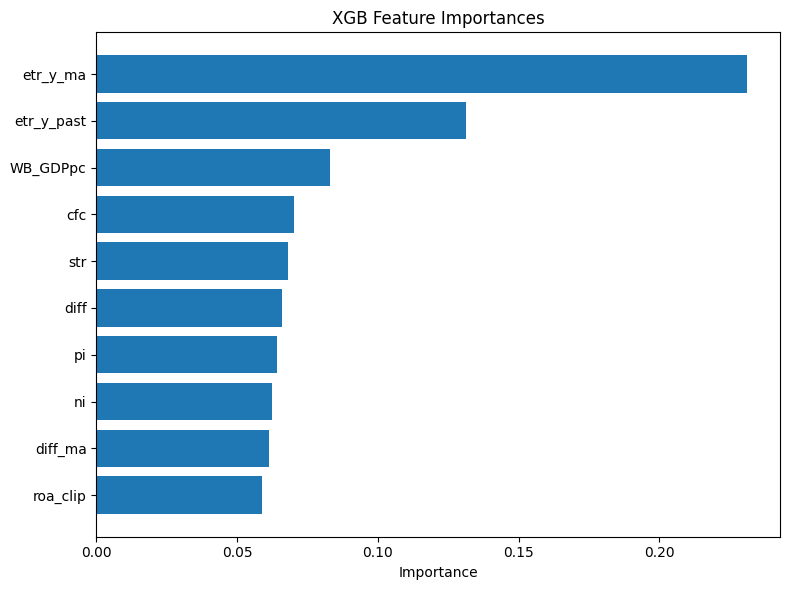

In [88]:
# feature importance
feature_importance_xgb = get_feature_importance_df(best_model_xgb, best_features_xgb)
plot_feature_importances(feature_importance_xgb, model_name="XGB", top_n=10)

In [90]:
xgb_best_model, xgb_best_features, xgb_results_df = optimize_features_with_rolling_cv(
    X=X_cleaned,
    y=y_full,
    years_array=years_array,
    rolling_cv_func=rolling_cv_xgboost_by_year_random,
    fr=fr,
    top_n_candidates=[20, 40, 60],
    verbose=1
)


Running rolling CV for top-20 features...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'reg_lambda': 1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.07, 'gamma': 0, 'colsample_bytree': 0.9}
Best CV RMSE: 0.15106202314142872

Running rolling CV for top-40 features...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'reg_lambda': 1, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Best CV RMSE: 0.14746842467424714

Running rolling CV for top-60 features...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best parameters: {'reg_lambda': 2, 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.07, 'gamma': 0.1, 'colsample_bytree': 1.0}
Best CV RMSE: 0.14776184945573595

Best top-N: 40, num_features: 40, CV RMSE: 0.1475


In [91]:
# choose the best model based on rmse
best_xgb = best_model_xgb

In [92]:
# save as a pickle file
save_and_download_model(best_xgb , best_features_xgb, "best_xgb.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5. LightGBM

In [93]:
from lightgbm import early_stopping

def rolling_cv_lgbm_by_year(
    X,
    y,
    years_array,
    min_train_years=1,
    scoring="neg_mean_squared_error",
    n_iter=50,
    n_jobs=-1,
    verbose=1,
    random_state=42
):
    """
    Perform rolling cross-validation by year for LightGBM (LGBMRegressor)
    with hyperparameter tuning using RandomizedSearchCV and early stopping.

    """

    # 1) Build rolling splits by year
    cv_splits = list(year_rolling_splits(years_array, min_train_years=min_train_years))

    # 2) Base LGBMRegressor
    # Use a large n_estimators and let early stopping pick the best number of trees
    lgbm = LGBMRegressor(
        objective="regression",
        n_estimators=500,
        random_state=random_state,
        verbose=-1
    )

    # 3) Hyperparameter distributions for RandomizedSearch
    param_distributions = {
        "n_estimators":      [50, 100, 200, 300, 400, 500],
        "num_leaves":        [31, 63, 127],
        "max_depth":         [-1, 3, 5, 7],
        "learning_rate":     [0.03, 0.05, 0.07, 0.1, 0.15, 0.2],
        "min_split_gain":    [0.1, 0.2, 0.5, 1, 5],
        "min_child_samples": [10, 20, 40],
        "colsample_bytree":  [0.5, 0.6, 0.8, 1.0],
        "reg_alpha":         [0.0, 0.1, 0.5, 1.0],
        "reg_lambda":        [0.0, 0.1, 0.5, 1.0]
    }

    # 4) Randomized search with rolling splits
    rand_search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv_splits,
        scoring=scoring,
        n_jobs=n_jobs,
        verbose=verbose,
        random_state=random_state,
        refit=True
    )

    # 5) Fit with callbacks instead of early_stopping_rounds kwarg
    rand_search.fit(
        X,
        y,
    )

    best_model = rand_search.best_estimator_

    # Convert best_score_ (negative MSE) to positive RMSE
    best_mse = -rand_search.best_score_
    best_rmse = np.sqrt(best_mse)
    cv_results_df = pd.DataFrame({"cv_rmse": [best_rmse]})

    print("Best parameters:", rand_search.best_params_)
    print("Best CV RMSE:", best_rmse)

    return best_model, rand_search, cv_results_df


In [94]:
# clean X_full column
X = X_full.copy()
X.columns = clean_feature_names(X.columns)

In [95]:
best_lgbm, lgbm_random, _ = rolling_cv_lgbm_by_year (
    X=X,
    y=y_full,
    years_array=years_array,
    min_train_years=1,
    n_jobs=-1,
    verbose=1,
)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 500, 'min_split_gain': 0.2, 'min_child_samples': 40, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best CV RMSE: 0.14607282631559573


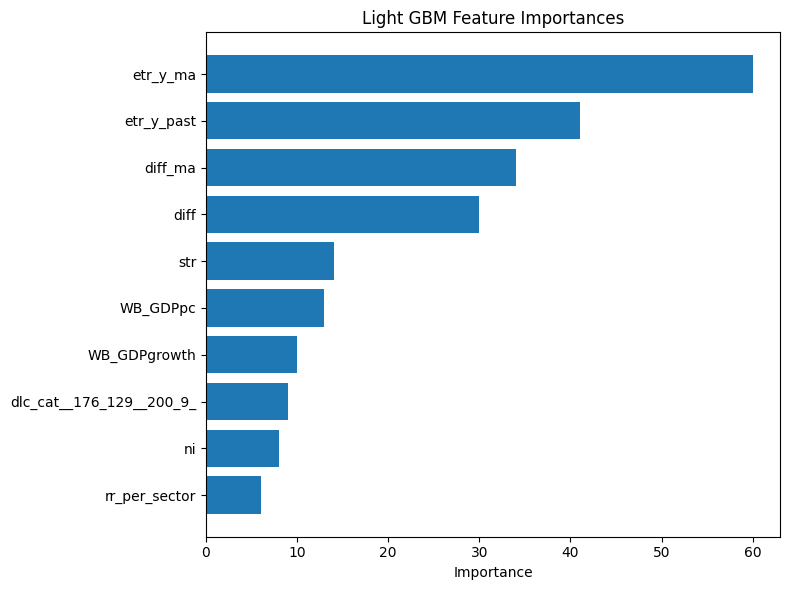

In [96]:
# feature importance
feature_importance_lgbm = get_feature_importance_df(best_lgbm, X.columns.tolist())
plot_feature_importances(feature_importance_lgbm, model_name="Light GBM", top_n=10)

In [105]:
# Selecting Important Features
feature_names = X.columns.tolist()
thresholds = [3, 2, 1]
results_df, best_thresh, best_features_lgbm, best_model_lgbm = find_best_threshold_with_cv_model(
    base_model=best_lgbm,
    X=X,
    y=y_full,
    years_array=years_array,
    feature_names=feature_names,
    thresholds=thresholds,
    rolling_cv_func=rolling_cv_lgbm_by_year,
    min_train_years=1,
    n_jobs=-1,
    verbose=1
)


Threshold 3: 16 features selected
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 127, 'n_estimators': 400, 'min_split_gain': 1, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.2, 'colsample_bytree': 0.5}
Best CV RMSE: 0.146047782123962

Threshold 2: 20 features selected
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 127, 'n_estimators': 400, 'min_split_gain': 1, 'min_child_samples': 10, 'max_depth': -1, 'learning_rate': 0.2, 'colsample_bytree': 0.5}
Best CV RMSE: 0.14554155807947847

Threshold 1: 30 features selected
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'reg_lambda': 1.0, 'reg_alpha': 0.5, 'num_leaves': 63, 'n_estimators': 300, 'min_split_gain': 0.2, 'min_child_samples': 40, 'max_depth': 5, 'learning_rate': 0.15, 'colsample_bytree': 0.6}
Best CV RMSE: 0.14572419

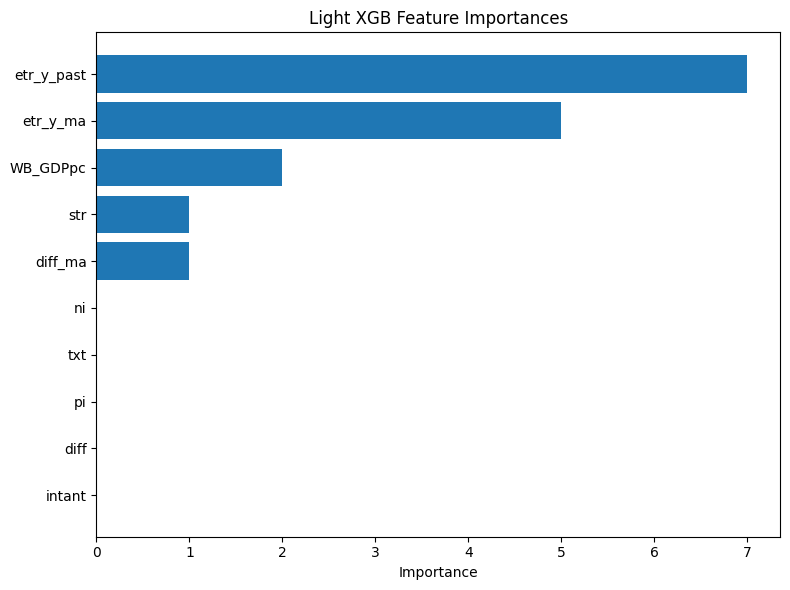

In [106]:
# feature importance
feature_importance_lgbm = get_feature_importance_df(best_model_lgbm, best_features_lgbm)
plot_feature_importances(feature_importance_lgbm, model_name="Light XGB", top_n=10)

In [109]:
lgbm_best_model, lgbm_best_features, lgbmresults_df = optimize_features_with_rolling_cv(
    X=X_full,
    y=y_full,
    years_array=years_array,
    rolling_cv_func=rolling_cv_lgbm_by_year,
    fr=fr,
    top_n_candidates=[20, 30, 40, 50, 60, 70],
    verbose=1
)


Running rolling CV for top-20 features...
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'reg_lambda': 0.0, 'reg_alpha': 0.1, 'num_leaves': 63, 'n_estimators': 50, 'min_split_gain': 0.1, 'min_child_samples': 10, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Best CV RMSE: 0.1525971681621365

Running rolling CV for top-30 features...
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'reg_lambda': 0.0, 'reg_alpha': 0.1, 'num_leaves': 63, 'n_estimators': 50, 'min_split_gain': 0.1, 'min_child_samples': 10, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.5}
Best CV RMSE: 0.14915989421636172

Running rolling CV for top-40 features...
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best parameters: {'reg_lambda': 1.0, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 500, 'min_split_gain': 0.1, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.15, 'colsample_bytree': 0.8}


In [110]:
# choose the best model based on rmse
best_lgbm = best_model_lgbm

In [111]:
# save as a pickle file
save_and_download_model(best_lgbm, best_features_lgbm, "best_lgbm.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6. CatBoost

In [113]:
def rolling_cv_catboost_by_year(
    X,
    y,
    years_array,
    min_train_years: int = 1,
    scoring: str = "neg_mean_squared_error",
    n_iter=20,
    n_jobs=-1,
    verbose=1,
    random_state=42
):
    """
    Perform rolling cross-validation by year for CatBoostRegressor
    with hyperparameter tuning using RandomizedSearchCV.

    """

    # 1) Build rolling splits by year
    cv_splits = list(year_rolling_splits(years_array, min_train_years=min_train_years))

    # 2) Base CatBoost model
    base_model = CatBoostRegressor(
        loss_function="RMSE",
        random_seed=random_state,
        verbose=False,  # turn off internal CatBoost logging
        thread_count=n_jobs if n_jobs is not None else -1,
        iterations=500  # fixed number of trees
    )

    # 3) Hyperparameter distributions
    param_distributions = {
        "depth": [3, 4, 5, 6],
        "learning_rate": [0.05, 0.07, 0.1, 0.15],
        "iterations": [100, 200, 300, 400],
        "l2_leaf_reg": [1, 3, 5, 7],
        "border_count": [32, 64, 128, 254],
        "bagging_temperature": [0.0, 0.5, 1.0],
        "min_data_in_leaf": [1, 5, 10, 20],
    }

    # 4) RandomizedSearchCV with rolling splits
    rand_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv_splits,
        scoring=scoring,
        n_jobs=n_jobs,
        verbose=verbose,
        random_state=random_state,
        refit=True
    )

    # 5) Fit
    rand_search.fit(X, y)

    # Best model and RMSE
    best_model = rand_search.best_estimator_
    best_mse = -rand_search.best_score_
    best_rmse = np.sqrt(best_mse)
    cv_results_df = pd.DataFrame({"cv_rmse": [best_rmse]})


    print("Best parameters:", rand_search.best_params_)
    print("Best CV RMSE:", best_rmse)

    return best_model, rand_search, cv_results_df

In [114]:
best_cat, cat_random, _ = rolling_cv_catboost_by_year (
    X=X_full,
    y=y_full,
    years_array=years_array,
    min_train_years=1,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'min_data_in_leaf': 5, 'learning_rate': 0.07, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.5}
Best CV RMSE: 0.14880590475192676


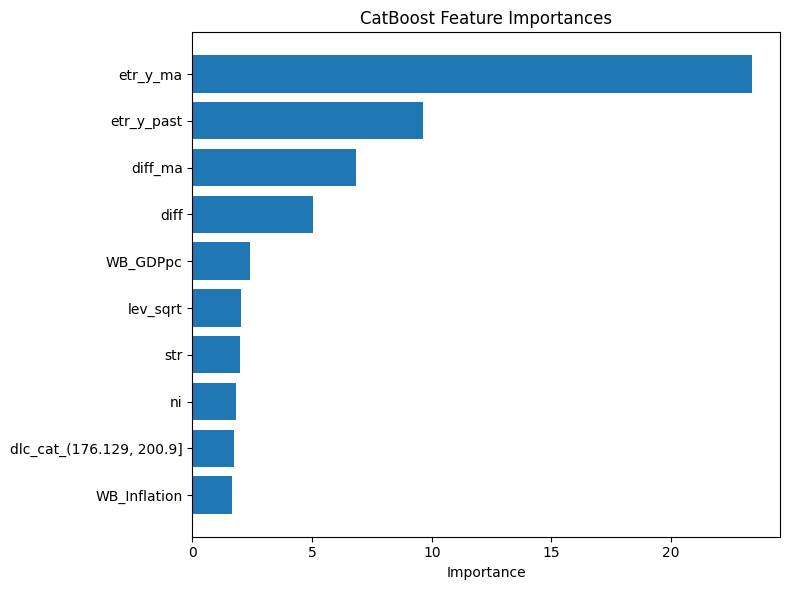

In [115]:
# feature importance
feature_importance_cat = get_feature_importance_df(best_cat, X_full.columns.tolist())
plot_feature_importances(feature_importance_cat, model_name="CatBoost", top_n=10)

In [118]:
# Selecting Important Features
feature_names = X_full.columns.tolist()
thresholds = [0.2, 0.1, 0.05]
results_df, best_thresh, best_features_cat, best_model_cat = find_best_threshold_with_cv_model(
    base_model=best_cat,
    X=X_full,
    y=y_full,
    years_array=years_array,
    feature_names=feature_names,
    thresholds=thresholds,
    rolling_cv_func=rolling_cv_catboost_by_year,
    min_train_years=1,
    n_jobs=-1,
    verbose=1
)


Threshold 0.2: 62 features selected
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'min_data_in_leaf': 5, 'learning_rate': 0.07, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.5}
Best CV RMSE: 0.14876238600174632

Threshold 0.1: 70 features selected
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'min_data_in_leaf': 5, 'learning_rate': 0.07, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.5}
Best CV RMSE: 0.1489098028749431

Threshold 0.05: 78 features selected
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'min_data_in_leaf': 5, 'learning_rate': 0.07, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.5}
Best CV RMSE: 0.1491869966387164

Best threshold: 0.2, num_features: 62, CV RMSE: 0.1488


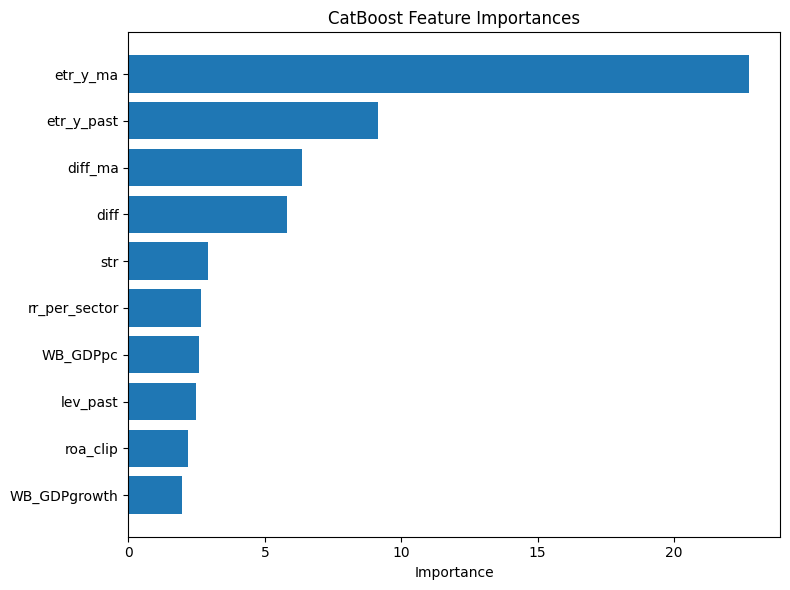

In [119]:
# feature importance
feature_importance_cat = get_feature_importance_df(best_model_cat, best_features_cat)
plot_feature_importances(feature_importance_cat, model_name="CatBoost", top_n=10)

In [121]:
cat_best_model, cat_best_features, cat_results_df = optimize_features_with_rolling_cv(
    X=X_full,
    y=y_full,
    years_array=years_array,
    rolling_cv_func=rolling_cv_catboost_by_year,
    fr=fr,
    top_n_candidates=[50, 60, 70],
    verbose=1
)


Running rolling CV for top-50 features...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'min_data_in_leaf': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'iterations': 100, 'depth': 6, 'border_count': 32, 'bagging_temperature': 0.0}
Best CV RMSE: 0.14633708341978838

Running rolling CV for top-60 features...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'min_data_in_leaf': 5, 'learning_rate': 0.07, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.5}
Best CV RMSE: 0.14633107962254574

Running rolling CV for top-70 features...
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'min_data_in_leaf': 5, 'learning_rate': 0.07, 'l2_leaf_reg': 5, 'iterations': 100, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.5}
Best CV RMSE: 0.14563755052780988

Best top-N: 70, num_features: 70, CV RMSE: 0.1456


In [122]:
# choose the best model based on rmse
best_cat = cat_best_model

In [123]:
# save as a pickle file
save_and_download_model(best_cat, cat_best_features, "best_cat.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [243]:
X_full.columns

Index(['ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt',
       ...
       'intan_ma', 'ppe_ma', 'sale_ma', 'cash_holdings_ma', 'roa_past',
       'lev_past', 'intan_past', 'ppe_past', 'sale_past',
       'cash_holdings_past'],
      dtype='object', length=111)

# Compare all models

In [5]:
import os
import pickle
import joblib

In [8]:
# load test dataset
df_test = pd.read_csv(f"{preprocessed_output_data_path}/test_fe.csv", index_col=0)
df_test.head()

,Ticker,Nazwa2,rok,ta,txt,pi,str,xrd,ni,ppent,...,intan_ma,ppe_ma,sale_ma,cash_holdings_ma,roa_past,lev_past,intan_past,ppe_past,sale_past,cash_holdings_past
11,11B PW Equity,11 bit studios SA,2016,45.649399,2.8015,15.730800,0.19,0.0,12.929300,0.7795,...,0.130887,0.009081,0.539652,0.527618,0.352416,0.000000,0.194652,0.013346,0.534162,0.699963
23,1AT PW Equity,Atal SA/Poland,2016,1513.552979,15.9150,109.042999,0.19,0.0,89.442001,7.4800,...,0.066162,0.007559,0.360836,0.100509,0.039084,0.196057,0.052127,0.006567,0.171832,0.107148
35,4FM PW Equity,4Fun Media SA,2016,41.662998,0.3202,1.489200,0.19,0.0,1.346000,5.6048,...,0.496920,0.087819,0.470287,0.056824,0.067262,0.014443,0.564584,0.152826,0.469210,0.042710
47,AAL LN Equity,Anglo American PLC,2016,50149.000000,698.0000,2624.000000,0.20,1594.0,28719.000000,63.0000,...,0.062258,0.001563,0.337668,0.117395,0.569492,0.345433,0.065253,0.001596,0.331651,0.132563
59,ABC PW Equity,ABC Data SA,2016,1252.895020,5.0190,22.233000,0.19,0.0,17.135000,10.2290,...,0.045939,0.005163,1.820588,0.032882,0.043842,0.090251,0.043249,0.004455,1.713010,0.030002


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 11 to 4355
Columns: 115 entries, Ticker to cash_holdings_past
dtypes: float64(57), int64(56), object(2)
memory usage: 329.0+ KB


In [10]:
# define X_train and y_train with all features
X_test = df_test.drop(['etr','Ticker', 'Nazwa2'], axis=1).copy()
y_test = df_test['etr'].copy()

In [11]:
# sort X_test by year
X_test = X_test.sort_values(by='rok').reset_index(drop=True)

# drop year column
X_test.drop('rok', axis=1, inplace=True)


In [12]:
X_test_cleaned = X_test.copy()
X_test_cleaned.columns = clean_feature_names(X_test_cleaned.columns)

In [13]:
!git clone https://github.com/MaiTran101/ML-2.git


fatal: destination path 'ML-2' already exists and is not an empty directory.


In [14]:
models_dir = '/content/ML-2/Models'

# List all pickle files in the directory
model_files = [f for f in os.listdir(models_dir) if f.endswith('.pkl')]

# Load models and their feature subsets
models = []
features_list = []
for file_name in model_files:
    path = os.path.join(models_dir, file_name)
    with open(path, 'rb') as f:
        data = pickle.load(f)  # this is a tuple: (model, feature_list)
        model, features = data  # unpack the tuple
        models.append(model)
        features_list.append(features)


In [15]:
for file_name in model_files:
    path = os.path.join(models_dir, file_name)

    with open(path, 'rb') as f:
        model, features = pickle.load(f)  # tuple: (model, features)

    print(f"Model {file_name} has {len(features)} features.")

Model best_lgbm.pkl has 20 features.
Model best_ada.pkl has 7 features.
Model best_cat.pkl has 70 features.
Model best_xgb.pkl has 15 features.
Model best_gbm.pkl has 50 features.
Model best_gbm_hist.pkl has 29 features.


In [16]:
# Use X_test_cleaned as your test set
test_columns = set(X_test_cleaned.columns)

# Loop through models and check for missing features
for file_name in model_files:
    path = os.path.join(models_dir, file_name)

    with open(path, 'rb') as f:
        model, features = pickle.load(f)  # tuple: (model, features)

    # Find features that the model expects but are missing in the test set
    missing_features = [f for f in features if f not in test_columns]

    if missing_features:
        print(f"\nModel {file_name} is missing these features in X_test_cleaned:")
        print(missing_features)
    else:
        print(f"\nModel {file_name} has all features present.")


Model best_lgbm.pkl has all features present.

Model best_ada.pkl has all features present.

Model best_cat.pkl has all features present.

Model best_xgb.pkl has all features present.

Model best_gbm.pkl has all features present.

Model best_gbm_hist.pkl is missing these features in X_test_cleaned:
['dlc_cat_(42.262, 176.129]']


In [17]:
X_lgbm = X_test_cleaned.copy()
features_lgbm = features_list[0]

for f in features_lgbm:
    if f not in X_lgbm.columns:
        X_lgbm[f] = 0

X_lgbm = X_lgbm[features_lgbm]
preds_lgbm = models[0].predict(X_lgbm)

In [18]:
X_ada = X_test_cleaned.copy()
features_ada = features_list[1]

for f in features_ada:
    if f not in X_ada.columns:
        X_ada[f] = 0

X_ada = X_ada[features_ada]
preds_ada = models[1].predict(X_ada)

In [19]:
X_cat = X_test_cleaned.copy()
features_cat = features_list[2]

for f in features_cat:
    if f not in X_cat.columns:
        X_cat[f] = 0

X_cat = X_cat[features_cat]
preds_cat = models[2].predict(X_cat)

In [20]:
X_xgb = X_test_cleaned.copy()
features_xgb = features_list[3]

for f in features_xgb:
    if f not in X_xgb.columns:
        X_xgb[f] = 0

X_xgb = X_xgb[features_xgb]
preds_xgb = models[3].predict(X_xgb)

In [21]:
X_gbm = X_test_cleaned.copy()
features_gbm = features_list[4]

for f in features_gbm:
    if f not in X_gbm.columns:
        X_gbm[f] = 0

X_gbm = X_gbm[features_gbm]
preds_gbm = models[4].predict(X_gbm)

In [22]:
# Mapping: test set column -> model expected name
rename_mapping = {
    'dlc_cat__42_262__176_129_': 'dlc_cat_(42.262, 176.129]'
}

X_test_copy = X_test_cleaned.copy()
X_test_copy.rename(columns=rename_mapping, inplace=True)

In [23]:
gbm_hist_model = models[5]
gbm_hist_features = features_list[5]

print("Features expected by best_gbm_hist.pkl:")
print(gbm_hist_features)

Features expected by best_gbm_hist.pkl:
['pi', 'str', 'ni', 'ppent', 'intant', 'dlc', 'revenue', 'diff', 'roa', 'lev', 'sale', 'capex2', 'y_v2x_polyarchy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'dlc_cat_(42.262, 176.129]', 'etr_y_past', 'etr_y_ma', 'diff_ma', 'roa_ma', 'lev_ma', 'cash_holdings_ma', 'roa_past', 'lev_past', 'intan_past', 'cash_holdings_past']


In [24]:
# Use X_test_cleaned
print("Columns in X_test_aligned:")
print(list(X_test_copy.columns))

Columns in X_test_aligned:
['ta', 'txt', 'pi', 'str', 'xrd', 'ni', 'ppent', 'intant', 'dlc', 'dltt', 'capex', 'revenue', 'cce', 'adv', 'diff', 'roa', 'lev', 'intan', 'rd', 'ppe', 'sale', 'cash_holdings', 'adv_expenditure', 'capex2', 'cfc', 'dta', 'capex2_scaled', 'y_v2x_polyarchy', 'y_e_p_polity', 'y_BR_Democracy', 'WB_GDPgrowth', 'WB_GDPpc', 'WB_Inflation', 'rr_per_country', 'rr_per_sector', 'sektor_consumer_discretionary', 'sektor_consumer_staples', 'sektor_energy', 'sektor_health_care', 'sektor_industrials', 'sektor_materials', 'sektor_real_estate', 'sektor_technology', 'sektor_utilities', 'gielda_2', 'gielda_3', 'gielda_4', 'gielda_5', 'ta_log', 'txt_cat___63_011___34_811_', 'txt_cat___34_811__0_488_', 'txt_cat__0_488__24_415_', 'txt_cat__24_415__25_05_', 'txt_cat__25_05__308_55_', 'txt_cat__308_55__327_531_', 'txt_cat__327_531__inf_', 'pi_cat___8975_0___1_523_', 'pi_cat___1_523__157_119_', 'pi_cat__157_119__465_9_', 'pi_cat__465_9__7875_5_', 'pi_cat__7875_5__8108_5_', 'pi_cat__810

In [32]:
# Get the features the model expects
expected_features = models[5].feature_names_in_

In [33]:
# Align X_test to those features
X_gbm_hist_ordered = X_test_copy.reindex(columns=expected_features, fill_value=0)

# Predict
preds_gbm_hist = models[5].predict(X_gbm_hist_ordered)

In [34]:
# Step 1: Put all predictions into a dictionary
preds_dict = {
    "gbm_hist": preds_gbm_hist,
    "lgbm": preds_lgbm,
    "xgb": preds_xgb,
    "ada": preds_ada,
    "cat": preds_cat,
    "gbm": preds_gbm,
}

# Step 2: Compute RMSE for each model
rmse_dict = {}
for model_name, preds in preds_dict.items():
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    rmse_dict[model_name] = rmse

# Step 3: Convert to DataFrame
rmse_df = pd.DataFrame(list(rmse_dict.items()), columns=["Model", "RMSE"])

# Step 4: Sort from smallest to biggest RMSE
rmse_df = rmse_df.sort_values(by="RMSE", ascending=True).reset_index(drop=True)

print(rmse_df)

      Model      RMSE
0      lgbm  0.095885
1       gbm  0.097621
2       xgb  0.098444
3       cat  0.100400
4       ada  0.102620
5  gbm_hist  0.105646


In [35]:
rmse_values = {
    "NAIVE MODEL": 0.167860,
    "OLS": 0.085129,
    "ARMA": 0.115057,
    "ARDL": 0.082121,
    "KNN": 0.094528,
    "SVR": 0.084485
}

# Step 2: Convert to DataFrame
rmse_df = pd.DataFrame(list(rmse_values.items()), columns=["Model", "RMSE"])

# Step 3: Sort from smallest to largest RMSE
rmse_df = rmse_df.sort_values(by="RMSE", ascending=True).reset_index(drop=True)

print(rmse_df)

         Model      RMSE
0         ARDL  0.082121
1          SVR  0.084485
2          OLS  0.085129
3          KNN  0.094528
4         ARMA  0.115057
5  NAIVE MODEL  0.167860


There  is no better model from gradient boosting family, but the results are not so different from each others.